<a href="https://colab.research.google.com/github/LCaravaggio/felicidad_y_redes/blob/main/GeoCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget "https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2020/quarter=2/2020-04-01_performance_fixed_tiles.zip"

--2024-05-23 17:29:37--  https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2020/quarter=2/2020-04-01_performance_fixed_tiles.zip
Resolving ookla-open-data.s3.amazonaws.com (ookla-open-data.s3.amazonaws.com)... 52.92.226.1, 52.92.228.185, 52.218.152.155, ...
Connecting to ookla-open-data.s3.amazonaws.com (ookla-open-data.s3.amazonaws.com)|52.92.226.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173577068 (166M) [application/zip]
Saving to: ‘2020-04-01_performance_fixed_tiles.zip’

2020-04-01_performa 100%[===================>] 165.54M  20.6MB/s    in 9.3s    

2024-05-23 17:29:47 (17.7 MB/s) - ‘2020-04-01_performance_fixed_tiles.zip’ saved [173577068/173577068]



In [ ]:
!wget "https://www.arcgis.com/sharing/rest/content/items/ad61dcd7dd244d4096c22a49cc97011f/data"

--2024-05-23 17:34:32--  https://www.arcgis.com/sharing/rest/content/items/ad61dcd7dd244d4096c22a49cc97011f/data
Resolving www.arcgis.com (www.arcgis.com)... 18.234.22.252, 18.234.22.249, 18.234.22.250
Connecting to www.arcgis.com (www.arcgis.com)|18.234.22.252|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ago-item-storage.s3.amazonaws.com/ad61dcd7dd244d4096c22a49cc97011f/shp_mapa_paises_mundo_2014.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEAEaCXVzLWVhc3QtMSJGMEQCIHTE6UIOZRt2K%2BXsKbGajdWS%2BWFfyUD4wdnEJ45bQBvtAiAYdmMRJmFig%2BPKtPo183RTP5kE2Ihr8hjkfvJAO36hliq0BQh6EAAaDDYwNDc1ODEwMjY2NSIMf0qLk7EG5voi9YvrKpEF3Tkeh7HH9XYGBnorvLE44rtMqvmvvLwkCqeVqhI5Mc9APccd%2BBwyo2WdP7r72EtkOSziN0kdVykBzfuZVEL4mUmym1hOJsyOdZAcXTIge7tp2YN8r5lMENAuEcoqXxz4SCT7hkUQ7SeLwEmV38jHy7FW8TPRHikDIe6KYx5%2Flhe%2BkumIltG0EIqe6bqxxgeTf55zxQyDme3pq9WbXXGPQ%2F2Z%2F4J1r3eTOFJeVyjTyHGjGcsxXhKdT6pZTOSxiO1d6n65Ie9toNEFtEq218fT1NyGrzjgKRdo%2FnJkxN8w27e5CfbULIbnyTzOjU1C8%2FpkTgypkgkVNlWQ

In [ ]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [ ]:
!pip install simpledbf
from simpledbf import Dbf5
dbf = Dbf5('/content/gps_fixed_tiles.dbf')
df = dbf.to_dataframe()

In [ ]:
!pip install pyquadkey2

from pyquadkey2 import quadkey

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyquadkey2: filename=pyquadkey2-0.3.1-cp310-cp310-linux_x86_64.whl size=152485 sha256=6257f888b84d39a3c955d354239427681b8a92e1206def51ff8bd095d3c06ae7
  Stored in directory: /root/.cache/pip/wheels/e5/43/6c/f04fea698df5b373536f71b64e7499715e4dffcb383ef88ce3
Successfully built pyquadkey2


In [ ]:
def qk_to_geo(quadkey_str, zoom_level):
    qk = quadkey.from_str(quadkey_str)
    lat_lon = qk.to_geo(zoom_level)
    return lat_lon

In [ ]:
df['geo'] = df['quadkey'].apply(qk_to_geo , zoom_level=1)

In [ ]:
df

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geo
0,0231113112003202,66216,12490,13,28,4,"(38.492294192361, -90.653686523437)"
1,1322111021111001,102598,37356,13,15,4,"(21.28937435586, 110.357666015625)"
2,3112203030003110,24686,18736,18,162,106,"(-34.921971036163, 138.598022460937)"
3,0320000130321312,17674,13989,78,364,4,"(40.225024210604, -87.632446289062)"
4,0320001332313103,441192,218955,22,14,1,"(38.920955420467, -84.737548828125)"
...,...,...,...,...,...,...,...
4877031,1322031000321100,55452,55740,6,1,1,"(16.383391123608, 98.684692382812)"
4877032,1220110033212313,37277,10907,20,3,1,"(39.989747184045, 18.0615234375)"
4877033,1221210121203010,661,1088,64,1,1,"(31.165809587861, 29.943237304687)"
4877034,1202322013330233,35493,14623,20,2,1,"(42.589488572714, 12.59033203125)"


In [ ]:
import geopandas as gpd

In [ ]:
from shapely.geometry import Point

df['geometry'] = df['geo'].apply(lambda x: Point(x[1], x[0]))

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geo,geometry
0,0231113112003202,66216,12490,13,28,4,"(38.492294192361, -90.653686523437)",POINT (-90.65369 38.49229)
1,1322111021111001,102598,37356,13,15,4,"(21.28937435586, 110.357666015625)",POINT (110.35767 21.28937)
2,3112203030003110,24686,18736,18,162,106,"(-34.921971036163, 138.598022460937)",POINT (138.59802 -34.92197)
3,0320000130321312,17674,13989,78,364,4,"(40.225024210604, -87.632446289062)",POINT (-87.63245 40.22502)
4,0320001332313103,441192,218955,22,14,1,"(38.920955420467, -84.737548828125)",POINT (-84.73755 38.92096)


In [ ]:
!pip install mapclassify

<Axes: xlabel='Longitud', ylabel='Latitud'>

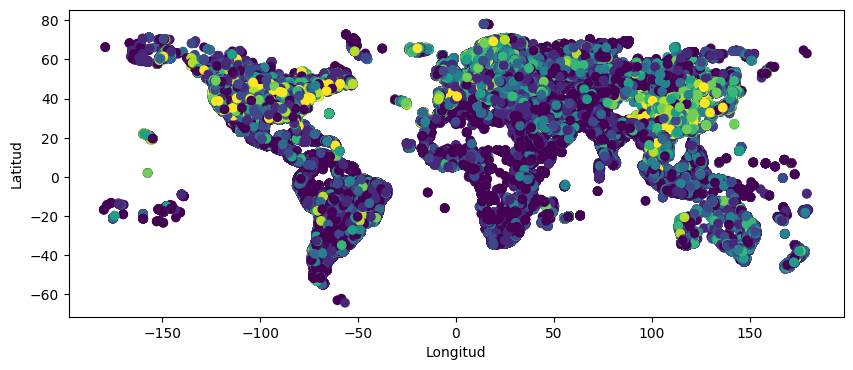

In [ ]:
import matplotlib.pyplot as plt
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Control del título y los ejes
#ax.set_title('Calidad de Internet', pad = 20, fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Añadir la leyenda separada del mapa
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="2%", pad=10)

# Mostrar el mapa finalizado
gdf.plot(column='avg_d_kbps', cmap='viridis',
         k=10, scheme='quantiles', ax=ax, zorder=5,
         legend=False)

In [ ]:
import requests
from bs4 import BeautifulSoup

def Citytolatlon(city):
  api_url = 'http://www.geonames.org/search.html?q={}'
  response = requests.get(api_url + city)
  text=""
  if response.status_code == requests.codes.ok:
    soup = BeautifulSoup(response.text, 'html.parser')
    td_elements = soup.find_all('td', nowrap=True)
    count = 0
    for td in td_elements:
      text += td.get_text(strip=True)
      count+=1

      if count == 2:
          break
  else:
      print("Error:", response.status_code, response.text)
  return text

In [ ]:
!pip install latlon3
import latlon

  Preparing metadata (setup.py) ... done
  Created wheel for latlon3: filename=latlon3-1.0.4-py3-none-any.whl size=31365 sha256=585bdb4edd37464c570786c13cfcd80840976c23707fabb44e23591616c55f3c
  Stored in directory: /root/.cache/pip/wheels/80/4d/11/7acb2342b2d16d9253d5cb76bbe83de3b7666bf57e27592ef6
Successfully built latlon3


In [ ]:
from latlon import Latitude, Longitude, string2latlon

In [ ]:
import re

class LL:
    __name__ = 'LatLon'
    def __init__(self, lat, lon, name=None):

        try:
            if lat.type() == 'GeoCoord':
                self.lat = lat
            else:
                raise AttributeError
        except AttributeError:
            self.lat = Latitude(lat)
        try:
            if lon.type() == 'GeoCoord':
                self.lon = lon
            else:
                raise AttributeError
        except AttributeError:
            self.lon = Longitude(lon)
        self.name = name

def toLatLong (texto):
  pattern = r"([SN])\s+(\d+)°\s+(\d+)′\s+(\d+)''([EW])\s+(\d+)°\s+(\d+)′\s+(\d+)''"

  matches = re.findall(pattern, texto.replace('�','°'))


  if matches:
    direction1, degrees1, minutes1, seconds1, direction2, degrees2, minutes2, seconds2 = matches[0]
    output_str1 = f"{degrees1} {minutes1} {seconds1} {direction1}"
    output_str2 = f"{degrees2} {minutes2} {seconds2} {direction2}"

  else:
    return ('0 0 0 S','0 0 0 W')

  return (output_str1, output_str2)

In [ ]:
import pandas as pd
base=pd.read_stata('LB2020.dta')

In [ ]:
lista_ciudades=base['ciudad'].unique()

In [ ]:
Citytolatlon('Buenos Aires'.encode('latin-1').decode('utf-8'))

"S 34° 36′ 47''W 58° 22′ 38''"

In [ ]:
toLatLong(Citytolatlon('Buenos Aires'.encode('latin-1').decode('utf-8')))

('34 36 47 S', '58 22 38 W')

In [ ]:
from latlon import string2latlon
string2latlon('34 36 47 S', '58 22 38 W','d% %m% %S% %H').to_string()

('-34.613055555555555', '-58.37722222222222')

In [ ]:
latsylongs=[]
for ciudad in lista_ciudades:
    # Get the latitude and longitude for the current city
    lat_lon = toLatLong(Citytolatlon(ciudad.encode('latin-1').decode('utf-8')))
    #print(ciudad.encode('latin-1').decode('utf-8'))
    # Append the lat_lon values as a list to the matrix
    a=string2latlon(lat_lon[0], lat_lon[1],'d% %m% %S% %H').to_string()
    latsylongs.append([ciudad.encode('latin-1').decode('utf-8'), a[0], a[1]])

# Create a DataFrame from the list of lists
ciudades_latlon = pd.DataFrame(latsylongs, columns=['City', 'Latitude', 'Longitude'])

In [ ]:
ciudades_latlon

,City,Latitude,Longitude
0,AR: Buenos Aires-Presidente Peron,-34.91777777777777,-58.37916666666667
1,AR: Capital Federal-Ciudad de Buenos Aires,-34.613055555555555,-58.37722222222222
2,AR: Buenos Aires-Suipacha,-34.75,-59.75
3,AR: Buenos Aires-Necochea,-38.55444444444444,-58.739444444444445
4,AR: Tucumán-Lules,-26.928611111111113,-65.33833333333332
...,...,...,...
1367,VE: Miranda-Acevedo,10.25,-66.33333333333333
1368,VE: Monagas-Caripe,10.166666666666666,-63.416666666666664
1369,VE: Trujillo-Candelaria,9.618055555555555,-70.35694444444444
1370,VE: Trujillo-Carache,9.666666666666666,-70.33333333333333


In [ ]:
ciudades_latlon['Latitude_num']=ciudades_latlon['Latitude'].astype(float)
ciudades_latlon['Longitude_num']=ciudades_latlon['Longitude'].astype(float)

In [ ]:
(ciudades_latlon['Latitude_num'] != 0).sum()

1168

In [ ]:
from scipy.spatial import cKDTree
import numpy as np

kdtree = cKDTree(df['geo'].apply(lambda x: (np.radians(x[0]), np.radians(x[1]))).tolist())

def find_nearest_city(row):
    lat, lon = np.radians(row['Latitude_num']), np.radians(row['Longitude_num'])
    dist, idx = kdtree.query([lat, lon])
    return df.at[idx, 'avg_d_kbps']

ciudades_latlon['avg_d_kbps'] = ciudades_latlon.apply(find_nearest_city, axis=1)

In [ ]:
ciudades_latlon

,City,Latitude,Longitude,Latitude_num,Longitude_num,avg_d_kbps
0,AR: Buenos Aires-Presidente Peron,-34.91777777777777,-58.37916666666667,-34.917778,-58.379167,35268
1,AR: Capital Federal-Ciudad de Buenos Aires,-34.613055555555555,-58.37722222222222,-34.613056,-58.377222,39905
2,AR: Buenos Aires-Suipacha,-34.75,-59.75,-34.750000,-59.750000,13959
3,AR: Buenos Aires-Necochea,-38.55444444444444,-58.739444444444445,-38.554444,-58.739444,13672
4,AR: Tucumán-Lules,-26.928611111111113,-65.33833333333332,-26.928611,-65.338333,7989
...,...,...,...,...,...,...
1367,VE: Miranda-Acevedo,10.25,-66.33333333333333,10.250000,-66.333333,2282
1368,VE: Monagas-Caripe,10.166666666666666,-63.416666666666664,10.166667,-63.416667,6245
1369,VE: Trujillo-Candelaria,9.618055555555555,-70.35694444444444,9.618056,-70.356944,168
1370,VE: Trujillo-Carache,9.666666666666666,-70.33333333333333,9.666667,-70.333333,168


In [ ]:
ciudades_latlon.to_csv('ciudades_latlon.csv')

In [ ]:
ciudades_latlon['geometry'] = ciudades_latlon.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [ ]:
ciudades_latlon

,City,Latitude,Longitude,Latitude_num,Longitude_num,avg_d_kbps,geometry
0,AR: Buenos Aires-Presidente Peron,-34.91777777777777,-58.37916666666667,-34.917778,-58.379167,35268,POINT (-58.37916666666667 -34.91777777777777)
1,AR: Capital Federal-Ciudad de Buenos Aires,-34.613055555555555,-58.37722222222222,-34.613056,-58.377222,39905,POINT (-58.37722222222222 -34.613055555555555)
2,AR: Buenos Aires-Suipacha,-34.75,-59.75,-34.750000,-59.750000,13959,POINT (-59.75 -34.75)
3,AR: Buenos Aires-Necochea,-38.55444444444444,-58.739444444444445,-38.554444,-58.739444,13672,POINT (-58.739444444444445 -38.55444444444444)
4,AR: Tucumán-Lules,-26.928611111111113,-65.33833333333332,-26.928611,-65.338333,7989,POINT (-65.33833333333332 -26.928611111111113)
...,...,...,...,...,...,...,...
1367,VE: Miranda-Acevedo,10.25,-66.33333333333333,10.250000,-66.333333,2282,POINT (-66.33333333333333 10.25)
1368,VE: Monagas-Caripe,10.166666666666666,-63.416666666666664,10.166667,-63.416667,6245,POINT (-63.416666666666664 10.166666666666666)
1369,VE: Trujillo-Candelaria,9.618055555555555,-70.35694444444444,9.618056,-70.356944,168,POINT (-70.35694444444444 9.618055555555555)
1370,VE: Trujillo-Carache,9.666666666666666,-70.33333333333333,9.666667,-70.333333,168,POINT (-70.33333333333333 9.666666666666666)


In [ ]:
gdf = gpd.GeoDataFrame(ciudades_latlon, geometry='geometry')
gdf.head()

,City,Latitude,Longitude,Latitude_num,Longitude_num,avg_d_kbps,geometry
0,AR: Buenos Aires-Presidente Peron,-34.91777777777777,-58.37916666666667,-34.917778,-58.379167,35268,POINT (-58.37917 -34.91778)
1,AR: Capital Federal-Ciudad de Buenos Aires,-34.613055555555555,-58.37722222222222,-34.613056,-58.377222,39905,POINT (-58.37722 -34.61306)
2,AR: Buenos Aires-Suipacha,-34.75,-59.75,-34.750000,-59.750000,13959,POINT (-59.75000 -34.75000)
3,AR: Buenos Aires-Necochea,-38.55444444444444,-58.739444444444445,-38.554444,-58.739444,13672,POINT (-58.73944 -38.55444)
4,AR: Tucumán-Lules,-26.928611111111113,-65.33833333333332,-26.928611,-65.338333,7989,POINT (-65.33833 -26.92861)


<Axes: xlabel='Longitud', ylabel='Latitud'>

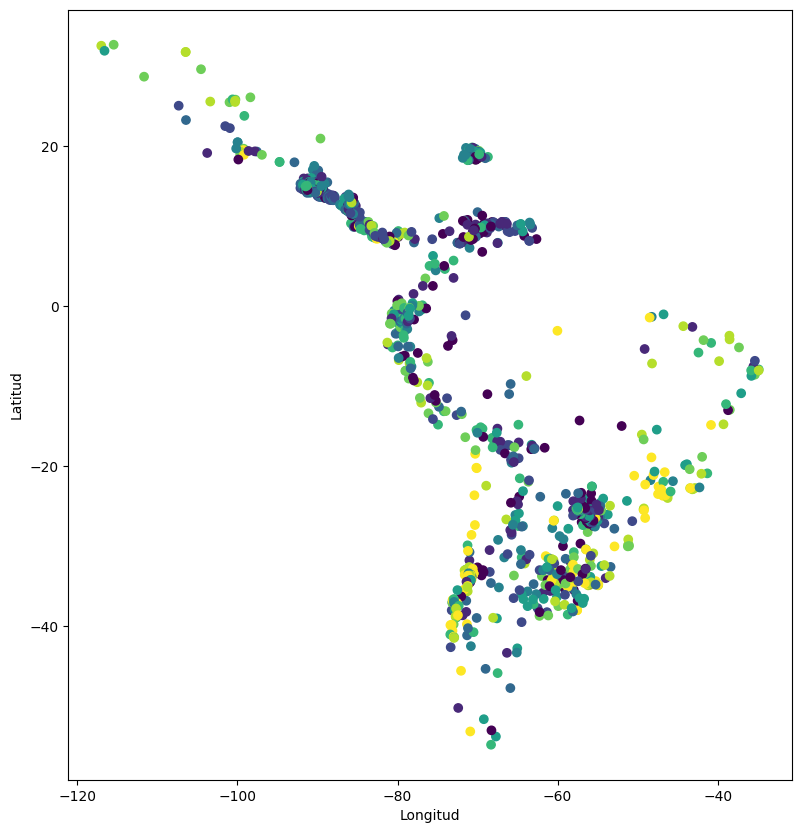

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Control del título y los ejes
#ax.set_title('Calidad de Internet', pad = 20, fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el mapa finalizado
gdf[gdf['Longitude_num'] <= -20].plot(column='avg_d_kbps', cmap='viridis',
         k=10, scheme='quantiles', ax=ax, zorder=5,
         legend=False)

# 2018

In [ ]:
!wget "https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.zip"

--2024-05-23 18:27:03--  https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.zip
Resolving ookla-open-data.s3.amazonaws.com (ookla-open-data.s3.amazonaws.com)... 52.92.136.177, 52.92.191.89, 52.92.129.161, ...
Connecting to ookla-open-data.s3.amazonaws.com (ookla-open-data.s3.amazonaws.com)|52.92.136.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290431451 (277M) [application/zip]
Saving to: ‘2019-01-01_performance_fixed_tiles.zip’

2019-01-01_performa 100%[===================>] 276.98M  17.8MB/s    in 16s     

2024-05-23 18:27:20 (17.4 MB/s) - ‘2019-01-01_performance_fixed_tiles.zip’ saved [290431451/290431451]



In [ ]:
for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [ ]:
dbf = Dbf5('/content/gps_fixed_tiles.dbf')
df = dbf.to_dataframe()

In [ ]:
df['geo'] = df['quadkey'].apply(qk_to_geo , zoom_level=1)

In [ ]:
df['geometry'] = df['geo'].apply(lambda x: Point(x[1], x[0]))

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geo,geometry
0,0231113112003202,66216,12490,13,28,4,"(38.492294192361, -90.653686523437)",POINT (-90.65369 38.49229)
1,1322111021111001,102598,37356,13,15,4,"(21.28937435586, 110.357666015625)",POINT (110.35767 21.28937)
2,3112203030003110,24686,18736,18,162,106,"(-34.921971036163, 138.598022460937)",POINT (138.59802 -34.92197)
3,0320000130321312,17674,13989,78,364,4,"(40.225024210604, -87.632446289062)",POINT (-87.63245 40.22502)
4,0320001332313103,441192,218955,22,14,1,"(38.920955420467, -84.737548828125)",POINT (-84.73755 38.92096)


In [ ]:
base=pd.read_stata('LB2018.dta')

In [ ]:
lista_ciudades=base['city'].unique()

In [ ]:
lista_ciudades

array(['AR: Capital Federal-Ciudad de Buenos Aires',
       'AR: Buenos Aires-Gran Buenos Aires', 'AR: Cordoba-Gran Cordoba',
       'AR: Santa Fe-Gran Rosario', 'AR: Mendoza-Gran Mendoza',
       'AR: Tucuman-Gran San Miguel de Tucuman',
       'AR: Buenos Aires-La Plata', 'AR: Buenos Aires-Mar del Plata',
       'AR: Salta-Gran Salta', 'AR: Tucuman-Tucuman',
       'AR: Neuquen-Plottier',
       'AR: Entre Rios-San Antonio de Padua de la Concordia',
       'AR: Buenos Aires-Tandil', 'AR: Cordoba-Villa Maria -Villa Nueva',
       'AR: Rio Negro-Villa Regina', 'AR: Buenos Aires-Baradero',
       'AR: Buenos Aires-Pinamar',
       'AR: Buenos Aires-San Clemente del Tuyu',
       'AR: Buenos Aires-Carhue', 'AR: Rio Negro-Chimpay',
       'AR: Santa Fe-Santa Clara de la Buena Vista', 'AR: Chaco-Basail',
       'AR: La Pampa-Telen', 'AR: Cordoba-Los Cedros',
       'BO: Beni-Trinidad', 'BO: Beni-Riberalta',
       'BO: Cochabamba-Nueva Galilea', 'BO: Chuquisaca-Sucre',
       'BO: Chuquisa

In [ ]:
latsylongs=[]
for ciudad in lista_ciudades:
    # Get the latitude and longitude for the current city
    lat_lon = toLatLong(Citytolatlon(ciudad.encode('latin-1').decode('utf-8')))
    #print(ciudad.encode('latin-1').decode('utf-8'))
    # Append the lat_lon values as a list to the matrix
    a=string2latlon(lat_lon[0], lat_lon[1],'d% %m% %S% %H').to_string()
    latsylongs.append([ciudad.encode('latin-1').decode('utf-8'), a[0], a[1]])

# Create a DataFrame from the list of lists
ciudades_latlon = pd.DataFrame(latsylongs, columns=['City', 'Latitude', 'Longitude'])

In [ ]:
ciudades_latlon

,City,Latitude,Longitude
0,AR: Capital Federal-Ciudad de Buenos Aires,-34.613055555555555,-58.37722222222222
1,AR: Buenos Aires-Gran Buenos Aires,-34.617777777777775,-58.477222222222224
2,AR: Cordoba-Gran Cordoba,-31.408055555555553,-64.21555555555555
3,AR: Santa Fe-Gran Rosario,-32.975,-60.681666666666665
4,AR: Mendoza-Gran Mendoza,-32.888888888888886,-68.84166666666667
...,...,...,...
193,CL: Valparaiso-Los Andes-Santa Tereza,0.0,0.0
194,CL: Metropolitana-Talagante,-33.66361111111111,-70.92722222222223
195,CL: Valparaiso-Pueblo de indios,-32.90694444444444,-71.21583333333334
196,CL: Libertador Bernardo OHiggins-Graneros,0.0,0.0


In [ ]:
ciudades_latlon['Latitude_num']=ciudades_latlon['Latitude'].astype(float)
ciudades_latlon['Longitude_num']=ciudades_latlon['Longitude'].astype(float)

In [ ]:
(ciudades_latlon['Latitude_num'] != 0).sum()

185

In [ ]:
kdtree = cKDTree(df['geo'].apply(lambda x: (np.radians(x[0]), np.radians(x[1]))).tolist())

ciudades_latlon['avg_d_kbps'] = ciudades_latlon.apply(find_nearest_city, axis=1)

In [ ]:
ciudades_latlon.to_csv('ciudades_latlon_2018.csv')